$\renewcommand{\inner}[2]{\left \langle #1 | #2 \right \rangle}$
$\newcommand{\dd}[1]{\frac{\text{d} #1}{\text{d}x}}$
# Analysis in Coordinate Space for $x^4$ Perturbation
The problem to be solved is the same as the one described in [x4-approximation.ipynb](https://github.com/snmendoza01/Physics-Simulations/blob/main/x4-perturbation/x4-approximation.ipynb). The approach to solve this is different and could be considered more general. We will not deal with the abstract _states_ $\ket{\psi}$, but rather with their coordinate representation $\inner{x}{\psi}\equiv \psi(x)$

### __Approach:__
We will still use the eigenstates of the QHO as a basis for the states, but we will use their coordinate representation: $\inner{x}{n} \equiv \frac{1}{\sqrt{2^n n! \sqrt{\pi}}}H_n(x) \, e^{-\frac{x^2}{2}} \eqqcolon \varphi_n(x)$, where $H_n$ is the nth Hemite polynomial. 

_Note:_ We have set $\omega = \hbar = m = 1$

One of the tools needed for this approach is the [Gaussian-Hermite Quadrature](https://mathworld.wolfram.com/Hermite-GaussQuadrature.html), as it will allow us to numerically integrate inner products and expectation values over the interval $(-\infty, \infty)$




In [465]:
import torch
from math import factorial
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from scipy.special import hermite
import numpy as np
from scipy.special.orthogonal import orthopoly1d
from numpy.polynomial.hermite import hermgauss

%matplotlib inline

# hyperparameters
w = 1
h = 1
lmbda = 0.25
N = 5
lr = 1e-3
epochs = 4000

hyperparams = {'lmbda': lmbda, 'lr': lr, 'epochs': epochs}

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


Then we proceed to define the functions we will need in order to implement the optimization of our parameters. First, we will be using the hermite polynomials as provided in the `scipy.special` module, as they provide an easy means for differentiation.

 We will define a simple function to transform elements of this class into object of type `callable`, as this is eassiest for implementing the gaussian quadrature. 

 Finally, we provide a function for computing this specific hamiltonian by acting with differential operators and multiplication by `x` on the functions. Note that, if the analysis of a different hamiltonian is desired, the function `inner_prod_hamiltonian()` needs to be altered internally. 

 The loss function is again given by: $$\mathfrak{L}(\ket{\psi_\Theta}) = \bra{\psi_\Theta}\hat{H}\ket{\psi_\Theta} = \sum_{i, j = 0}^N \bar{\alpha}_i \alpha_j \bra{i} \hat{H}\ket{j}\\ \equiv \sum_{i, j = 0}^N\bar{\alpha}_i \alpha_j\int_{\infty}^\infty\varphi_i^*(x)\left(\frac{1}{2} \frac{\text{d}^2}{\text{d}x^2}+\frac{1}{2}x^2 + \lambda x^4 \right)\varphi_j \text{d}x$$
 which we will approximate with a gaussian quadrature using the fact that:
 $$\int_{-\infty}^\infty e^{-x^2}f(x) \approx \sum_{n=0}^N w_i f(x_i)$$

 The optimization function, once the loss is given, is just standard optimization procedure. 

In [466]:
def orthopoly1d_to_func(poly: orthopoly1d):
    return lambda x: sum([coeff*x**(len(poly)-idx) for idx, coeff in enumerate(poly)])


def apply_quad(func, deg):
    xs, ws = hermgauss(deg)
    sum = 0
    for x, w in zip(xs, ws):
        sum += w*func(x)
    return sum


def inner_prod_hamiltonian(i: int , j: int, lmbda: float):
    i_poly, j_poly = (hermite(i, monic=False)/np.sqrt(np.sqrt(np.pi)*2**i*factorial(i)),
                      hermite(j, monic=False)/np.sqrt(np.sqrt(np.pi)*2**j*factorial(j)))
    first, second = orthopoly1d_to_func(j_poly.deriv()), orthopoly1d_to_func(j_poly.deriv().deriv())
    i_func = orthopoly1d_to_func(i_poly)
    j_func = orthopoly1d_to_func(j_poly)
    derivated = lambda x: second(x)-j_func(x)-2*x*first(x)+x**2*j_func(x)
    func = lambda x: i_func(x)*(-derivated(x)/2
                                +j_func(x)*x**2/2+lmbda*j_func(x)*x**4)
    # func = lambda x: i_func(x)*j_func(x)
    return apply_quad(func, max(i, j)+5)


def inner_prod_hamiltonian_2(i: int , j: int, lmbda: float):
    i_poly, j_poly = (hermite(i, monic=False)/np.sqrt(np.sqrt(np.pi)*2**i*factorial(i)),
                      hermite(j, monic=False)/np.sqrt(np.sqrt(np.pi)*2**j*factorial(j)))
    hamilt = lambda x: 0.5+i if i==j else 0
    i_func = orthopoly1d_to_func(i_poly)
    j_func = orthopoly1d_to_func(j_poly)
    func = lambda x: i_func(x)*(hamilt(x)*j_func(x) + lmbda*j_func(x)*x**4)
    return apply_quad(func, N+5)


def loss_fn(alpha: torch.Tensor, N: int, lmbda):
    loss = 0
    for i in range(N+1):
        for j in range(N+1):
            # print(inner_prod_hamiltonian(i, j, lmbda))
            loss += torch.conj(alpha[i]) * alpha[j] * inner_prod_hamiltonian(i, j, lmbda)/torch.norm(alpha)**2
    return torch.abs(loss)


def optimize(alpha, N, hyperparams):
    lr = hyperparams['lr']
    epochs = hyperparams['epochs']
    lmbda = hyperparams['lmbda']
    interv = 50
    # alpha_norm = alpha/torch.norm(alpha)
    optimizing_info = torch.zeros(epochs//interv, 2)
    optimizer = torch.optim.Adam([alpha], lr=lr)
    for step in trange(epochs):
        loss = loss_fn(alpha, N, lmbda)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        if not step%interv:
            print(f'step: {step} \nloss: {loss}\n------------')
            optimizing_info[step//interv][0] = step
            optimizing_info[step//interv][1] = loss
            
    return optimizing_info


We proceed to initialize random complex coefficients and optimize them. We also plot the result of the decay of the loss as a function of iteration number.

In [467]:
alpha = torch.rand(N+1,dtype=torch.cfloat, requires_grad=True)
plotting_info = optimize(alpha, N, hyperparams)

  0%|          | 0/4000 [00:00<?, ?it/s]

step: 0 
loss: 7.244208812713623
------------
step: 50 
loss: 6.600573539733887
------------
step: 100 
loss: 6.003478050231934
------------
step: 150 
loss: 5.399129867553711
------------
step: 200 
loss: 4.789654731750488
------------
step: 250 
loss: 4.20272159576416
------------
step: 300 
loss: 3.6616086959838867
------------
step: 350 
loss: 3.180964469909668
------------
step: 400 
loss: 2.766575336456299
------------
step: 450 
loss: 2.4170684814453125
------------
step: 500 
loss: 2.1264665126800537
------------
step: 550 
loss: 1.8866301774978638
------------
step: 600 
loss: 1.6890490055084229
------------
step: 650 
loss: 1.5258985757827759
------------
step: 700 
loss: 1.3905006647109985
------------
step: 750 
loss: 1.2774025201797485
------------
step: 800 
loss: 1.1822618246078491
------------
step: 850 
loss: 1.101662516593933
------------
step: 900 
loss: 1.032932162284851
------------
step: 950 
loss: 0.9739792943000793
------------
step: 1000 
loss: 0.92316359281539

Final loss: 0.6218642592430115


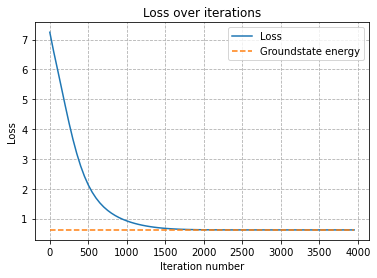

In [469]:
plt.plot(plotting_info[:, 0].detach().numpy(), plotting_info[:, 1].detach().numpy(), 
         label='Loss')
y = plotting_info[-1, 1].detach().numpy()
plt.plot(plotting_info[:, 0].detach().numpy(), [y]*len(plotting_info[:, 0]),
         ls='--', label='Groundstate energy')
plt.grid(ls='--')
plt.legend()
plt.title('Loss over iterations')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
print(f'Final loss: {y}')